In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
#for roc and auc
from sklearn import metrics

#below needed to display decision tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
# from sklearn.metrics import mean_squared_error

import json
import requests
from bs4 import BeautifulSoup

#import my function files
import webscrape_wiki_table
import config
import query_helper
import time

#utilities file for timer
from utilities import *

### Clean mushroom data

In [84]:
hymeniumType =  ['gills'   
                ,'pores'
                ,'smooth'
                ,'ridges'
                ,'teeth'
                ,'gleba']

In [85]:
capShape =  ['campanulate'
            ,'conical'
            ,'convex'
            ,'depressed'
            ,'flat'
            ,'infundibuliform'
            ,'offset'
            ,'ovate'
            ,'umbilicate'
            ,'umbonate'
            ,'no'
            ,'NA']

In [86]:
whichGills = ['adnate'
            ,'adnexed'
            ,'decurrent'
            ,'emarginate'
            ,'free'
            ,'seceding'
            ,'sinuate'
            ,'subdecurrent'
            ,'no'
            ,'NA']

In [87]:
stipeCharacter = ['bare'
                ,'ring'
                ,'volva'
                ,'ring_and_volva'
                ,'cortina'
                ,'NA']

In [88]:
sporePrintColor = ['black'
                    ,'blackish-brown'
                    ,'brown'
                    ,'buff'
                    ,'cream'
                    ,'green'
                    ,'ochre'
                    ,'olive'
                    ,'olive-brown'
                    ,'pink'
                    ,'pinkish-brown'
                    ,'purple'
                    ,'purple-black'
                    ,'purple-brown'
                    ,'reddish-brown'
                    ,'salmon'
                    ,'tan'
                    ,'white'
                    ,'yellow'
                    ,'yellow-orange'
                    ,'yellow-brown']

In [89]:
ecologicalType =['mycorrhizal'
                ,'parasitic'
                ,'saprotrophic']

In [90]:
howEdible = ['choice'
            ,'edible'
            ,'inedible'
            ,'unpalatable'
            ,'caution'
            ,'psychoactive'
            ,'poisonous'
            ,'allergenic'
            ,'deadly'
            ,'unknown']

In [91]:
mushroom_features = [hymeniumType, capShape, whichGills, stipeCharacter, sporePrintColor, ecologicalType, howEdible]

In [92]:
query ='''SELECT * FROM mushroom.wiki_mush;)'''

In [93]:
df = query_helper.query_to_df(query)
df.to_csv('wiki_mush_db.csv')      #saves the file for use later without needing to connect to AWS db
df.head()

,name,hymeniumType,capShape,whichGills,stipeCharacter,sporePrintColor,ecologicalType,howEdible
0,Lysurus mokusin,smooth hymenium,no distinct cap,hymenium attachment is irregular or not applic...,stipe is bare,spore print is olive-brown,ecology is saprotrophic,edibility: unknown
1,Agaricus abruptibulbus,gills on hymenium,cap is convex\n or flat,hymenium is free,stipe has a ring,spore print is brown,ecology is saprotrophic,edibility: edible
2,Agaricus amicosus,gills on hymenium,cap is convex\n or flat,hymenium is free,stipe has a ring,spore print is brown,ecology is saprotrophic,edibility: choice
3,Agaricus arvensis,gills on hymenium,cap is convex,hymenium is free,stipe has a ring,spore print is brown\n to blackish-brown,ecology is saprotrophic,edibility: choice
4,Agaricus augustus,gills on hymenium,cap is convex,hymenium is free,stipe has a ring,spore print is brown,ecology is saprotrophic,edibility: edible


## Take feature out of each string

In [94]:
#pull feature out of string **LIMITED TO FIRST MATCH CURRENTLY
def get_feature_type(feature, x):
    #clean string
    s = x.replace('\n', ' ') 
    s = s.split()
    
    #look at each word to find match
    for catagory in feature:
        if catagory in s:
            feat = catagory
            return feat
    return 'na'

In [95]:
for features, col in zip(mushroom_features, df.columns[1:]):
#     print(i)
    df[col] = df[col].apply(lambda x: get_feature_type(features, x))

In [96]:
df.whichGills.value_counts()

adnate          241
free            140
decurrent       113
adnexed          82
na               56
emarginate        5
seceding          2
subdecurrent      2
sinuate           1
Name: whichGills, dtype: int64

In [97]:
df.shape

(642, 8)

### Get genus from name

In [98]:
df['genus']= '0'
df['genus']= df['name'].apply(lambda x: (x.split()[0]) if len(x.split())==2 else x)

In [99]:
df.head()

,name,hymeniumType,capShape,whichGills,stipeCharacter,sporePrintColor,ecologicalType,howEdible,genus
0,Lysurus mokusin,smooth,no,na,bare,olive-brown,saprotrophic,unknown,Lysurus
1,Agaricus abruptibulbus,gills,convex,free,ring,brown,saprotrophic,edible,Agaricus
2,Agaricus amicosus,gills,convex,free,ring,brown,saprotrophic,choice,Agaricus
3,Agaricus arvensis,gills,convex,free,ring,blackish-brown,saprotrophic,choice,Agaricus
4,Agaricus augustus,gills,convex,free,ring,brown,saprotrophic,edible,Agaricus


#### Drop erroroneous names

In [100]:
index_to_drop = df[df['name']=='var.'].index

In [101]:
df.drop(index_to_drop, inplace=True)

#### Create list of genus only entries

In [102]:
bool_list = [True if len(name.split())==1 else False for name in df.name]

In [103]:
genus_names =list(df[bool_list].name.values)

In [104]:
genus_names

['Armillaria',
 'Blusher',
 'Caloscypha',
 'Cantharellus',
 'Craterellus',
 'Enokitake',
 'Galerina',
 'Matsutake',
 'Melanoleuca',
 'Mythicomyces',
 'Nidulariaceae',
 'Orellani',
 'pantherina',
 'Paragyrodon',
 'Phaeolepiota',
 'Pluteus',
 'Polyozellus',
 'Rhodotus',
 'Shiitake',
 'Volvopluteus']

#### Get other genus' and combine into list of unique genus

In [105]:
genus_names.extend(list(df.genus.unique()))

## Filling NA Values

### Create blank table of feature for each genus


In [106]:
genus_popular_features =pd.concat([pd.DataFrame([name], columns=['genus']) for name in genus_names],
                                  ignore_index=True)

In [107]:
#fill initial values with zero
genus_popular_features[list(df.columns[1:-2].values)] = pd.DataFrame([[0,0,0,0,0,0]], 
                                                                     index=genus_popular_features.index)
genus_popular_features.head()

,genus,hymeniumType,capShape,whichGills,stipeCharacter,sporePrintColor,ecologicalType
0,Armillaria,0,0,0,0,0,0
1,Blusher,0,0,0,0,0,0
2,Caloscypha,0,0,0,0,0,0
3,Cantharellus,0,0,0,0,0,0
4,Craterellus,0,0,0,0,0,0


In [108]:
#drop genus with var. in name
genus_popular_features.genus = genus_popular_features.genus.apply(lambda x: np.nan if 'var.' in x else x)
genus_popular_features.dropna(inplace=True)

### Now we'll get the most common feature for each genus

In [109]:

# pd.set_option('display.max_colwidth', -1)

In [110]:
df.groupby(['genus']).sum()

,name,hymeniumType,capShape,whichGills,stipeCharacter,sporePrintColor,ecologicalType,howEdible
genus,,,,,,,,
Agaricus,Agaricus abruptibulbusAgaricus amicosusAgaricu...,gillsgillsgillsgillsgillsgillsgillsgillsgillsg...,convexconvexconvexconvexconvexconvexconvexconv...,freefreefreefreefreefreefreefreefreefreefreefr...,ringringringringringringringringringbareringri...,brownbrownblackish-brownbrownbrownbrownbrownbr...,saprotrophicsaprotrophicsaprotrophicsaprotroph...,ediblechoicechoiceedibleediblechoicechoicechoi...
Agrocybe,Agrocybe praecox,gills,convex,adnexed,ring,brown,saprotrophic,edible
Albatrellus,Albatrellus subrubescens,pores,convex,decurrent,bare,white,mycorrhizal,poisonous
Aleuria,Aleuria aurantia,smooth,no,na,na,white,saprotrophic,edible
Amanita,Amanita abruptaAmanita aestivalisAmanita alboc...,gillsgillsgillsgillsgillsgillsgillsgillsgillsg...,convexconvexconvexconvexconvexconvexconvexconv...,freefreeadnatefreefreefreefreefreefreefreefree...,ringringvolvaringringringringringringringringr...,whitewhitewhitewhitewhitewhitewhitewhitewhitew...,mycorrhizalmycorrhizalmycorrhizalmycorrhizalmy...,deadlyunknowninediblepoisonousdeadlynanaunknow...
...,...,...,...,...,...,...,...,...
Volvariella,Volvariella bombycinaVolvariella surrectaVolva...,gillsgillsgills,conicalconvexconical,freefreefree,volvavolvavolva,pinkpinkish-brownsalmon,saprotrophicparasiticsaprotrophic,edibleinediblechoice
Volvopluteus,VolvopluteusVolvopluteus asiaticusVolvopluteus...,gillsgillsgillsgillsgills,flatflatflatflatflat,freefreefreefreefree,volvavolvavolvavolvavolva,pinkpinkpinkpinkpink,saprotrophicsaprotrophicsaprotrophicsaprotroph...,unpalatableunknownunknownedibleunknown
Xerocomellus,Xerocomellus zelleri,pores,convex,adnate,bare,olive-brown,mycorrhizal,edible


In [111]:
df_agg =df.groupby(['genus']).agg(['max'])
df_agg

,name,hymeniumType,capShape,whichGills,stipeCharacter,sporePrintColor,ecologicalType,howEdible
,max,max,max,max,max,max,max,max
genus,,,,,,,,
Agaricus,Agaricus xanthodermus,gills,flat,free,ring,purple-black,saprotrophic,poisonous
Agrocybe,Agrocybe praecox,gills,convex,adnexed,ring,brown,saprotrophic,edible
Albatrellus,Albatrellus subrubescens,pores,convex,decurrent,bare,white,mycorrhizal,poisonous
Aleuria,Aleuria aurantia,smooth,no,na,na,white,saprotrophic,edible
Amanita,Amanita zambiana,gills,umbonate,free,volva,white,saprotrophic,unknown
...,...,...,...,...,...,...,...,...
Volvariella,Volvariella volvacea,gills,convex,free,volva,salmon,saprotrophic,inedible
Volvopluteus,Volvopluteus michiganensis,gills,flat,free,volva,pink,saprotrophic,unpalatable


In [145]:
df_agg.replace('na', np.nan, inplace=True)

In [112]:
df_agg.columns

MultiIndex([(           'name', 'max'),
            (   'hymeniumType', 'max'),
            (       'capShape', 'max'),
            (     'whichGills', 'max'),
            ( 'stipeCharacter', 'max'),
            ('sporePrintColor', 'max'),
            ( 'ecologicalType', 'max'),
            (      'howEdible', 'max')],
           )

#### Next we'll fill the na values

In [113]:
df_agg.at['Agaricus',('capShape', 'max')]
# df_agg.at['row['genus'],(col, 'max')]

'flat'

In [141]:
df_agg.at['Bovista',('hymeniumType', 'max')]

'na'

In [152]:
#pull feature out of string **LIMITED TO FIRST MATCH CURRENTLY
def check_na_and_fill(row, col):
    
#     for col in df.columns[1:-2]:
# #         df[col] = df[col].apply(lambda x: check_na_and_fill(features, x))
    if row[col] == 'na':
        #find most common for genus and reassing mode
#         print('we found', row['genus'],col, 'at',row[col] )
        print('we found', row['genus'],col, 'with',row[col], 'most common is', df_agg.at[row['genus'],(col, 'max')])
        return row[col]
#         return df_agg.at[row['genus'],(col, 'max')]
    else:
        return row[col]

In [139]:
for col in df.columns[1:-2]:
    print(' ', col, ' ',(df[col] == 'na').sum(), (df[col] == np.nan).sum())

  hymeniumType   17 0
  capShape   0 0
  whichGills   56 0
  stipeCharacter   33 0
  sporePrintColor   0 0
  ecologicalType   0 0


In [140]:
for col in df.columns[1:-2]:
    df[col] = df.apply(lambda row: check_na_and_fill(row, col), axis=1)

we found Bovista hymeniumType with na most common is na
we found Caloscypha hymeniumType with na most common is na
we found Caloscypha hymeniumType with na most common is na
we found Calvatia hymeniumType with na most common is na
we found Clathrus hymeniumType with na most common is na
we found Clathrus hymeniumType with na most common is na
we found Daldinia hymeniumType with na most common is na
we found Handkea hymeniumType with na most common is na
we found Ileodictyon hymeniumType with na most common is na
we found Lycoperdon hymeniumType with na most common is na
we found Lycoperdon hymeniumType with na most common is na
we found Lycoperdon hymeniumType with na most common is na
we found Lycoperdon hymeniumType with na most common is na
we found Nidulariaceae hymeniumType with na most common is na
we found Pseudocolus hymeniumType with na most common is na
we found Scleroderma hymeniumType with na most common is na
we found Scleroderma hymeniumType with na most common is na
we f

In [117]:
for col in df.columns[1:-2]:
    print(df.isnull().sum())

name               0
hymeniumType       0
capShape           0
whichGills         0
stipeCharacter     0
sporePrintColor    0
ecologicalType     0
howEdible          0
genus              0
dtype: int64
name               0
hymeniumType       0
capShape           0
whichGills         0
stipeCharacter     0
sporePrintColor    0
ecologicalType     0
howEdible          0
genus              0
dtype: int64
name               0
hymeniumType       0
capShape           0
whichGills         0
stipeCharacter     0
sporePrintColor    0
ecologicalType     0
howEdible          0
genus              0
dtype: int64
name               0
hymeniumType       0
capShape           0
whichGills         0
stipeCharacter     0
sporePrintColor    0
ecologicalType     0
howEdible          0
genus              0
dtype: int64
name               0
hymeniumType       0
capShape           0
whichGills         0
stipeCharacter     0
sporePrintColor    0
ecologicalType     0
howEdible          0
genus              0
dty

In [118]:
df

,name,hymeniumType,capShape,whichGills,stipeCharacter,sporePrintColor,ecologicalType,howEdible,genus
0,Lysurus mokusin,smooth,no,na,bare,olive-brown,saprotrophic,unknown,Lysurus
1,Agaricus abruptibulbus,gills,convex,free,ring,brown,saprotrophic,edible,Agaricus
2,Agaricus amicosus,gills,convex,free,ring,brown,saprotrophic,choice,Agaricus
3,Agaricus arvensis,gills,convex,free,ring,blackish-brown,saprotrophic,choice,Agaricus
4,Agaricus augustus,gills,convex,free,ring,brown,saprotrophic,edible,Agaricus
...,...,...,...,...,...,...,...,...,...
637,Volvopluteus earlei,gills,flat,free,volva,pink,saprotrophic,unknown,Volvopluteus
638,Volvopluteus gloiocephalus,gills,flat,free,volva,pink,saprotrophic,edible,Volvopluteus
639,Volvopluteus michiganensis,gills,flat,free,volva,pink,saprotrophic,unknown,Volvopluteus
640,Xerocomellus zelleri,pores,convex,adnate,bare,olive-brown,mycorrhizal,edible,Xerocomellus


In [ ]:
df.count()

In [ ]:
for col in df.columns[1:-2]:
#     print(i)
    df[col] = df[col].apply(lambda x: check_na_and_fill(features, x))

In [ ]:
df[df.genus=='Agaricus']

In [ ]:
df[df.genus=='Lysurus']

## Feature Distributions

In [ ]:
df.columns[1:]

In [ ]:
f'hello my nema {df.columns}'

In [ ]:
for col in df.columns[1:]:
    plt.figure(figsize=(10,5))
    ax = sns.barplot(x=col, y=col, data=df, orient="v", estimator=lambda x: len(x) / len(df) * 100)
    ax.set(ylabel="Percent")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=65)
    plt.tight_layout()
#     plt.gcf().subplots_adjust(bottom=0.3)
    plt.savefig(f'graphs/{col}.png')

In [ ]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x="sporePrintColor", y="sporePrintColor", data=df, orient="v", estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel="Percent")
ax.set_xticklabels(ax.get_xticklabels(), rotation=65)
plt.tight_layout()



In [ ]:
# plt.figure(figsize=(10,5))
# ax = sns.barplot(x='hymeniumType', y='hymeniumType', data=df, orient="v", estimator=lambda x: len(x) / len(df) * 100)
# ax.set(ylabel="Percent")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=65)

In [ ]:
# plt.figure(figsize=(10,5))
# ax = sns.countplot(x="sporePrintColor", data=df)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=65)

In [ ]:
df.isin(['na']).sum()

In [ ]:
for col in df.columns[1:]:
    print(df[col].value_counts())

In [ ]:
#map edibiliy to binary groups
df.loc[:,'howEdible'] = df.howEdible.map(lambda x : {
    'edible'      : 'edible',
    'choice'      : 'edible',
    'psychoactive': 'edible',
    'inedible'    : 'inedible',
    'poisonous'   : 'inedible',
    'unknown'     : 'inedible',
    'deadly'      : 'inedible',
    'na'           : 'inedible',
    'unpalatable' : 'inedible'
}[x])

In [ ]:
df.howEdible.value_counts()

In [ ]:
df.head()

In [ ]:
df.describe()

In [ ]:
dfx=df.drop(columns=['name', 'howEdible'])
dfx.head()

# Further EDA 

#### Lets start by looking at target variable howEdible

In [ ]:
# edible Count
print('Target Variable')
print(df.groupby(['howEdible']).howEdible.count())

# Target Variable Countplot
# sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
sns.countplot(df['howEdible'], alpha =.80)
plt.title('Edible vs Inedible')
plt.ylabel('# Passengers')
plt.show()

Now lets get a general feel for all of the variable counts

In [ ]:
hc= dfx.hymeniumType.value_counts()
sns.barplot(hc.index, hc.values)
plt.title('hymeniumType')

In [ ]:
hc= dfx.capShape.value_counts()
plt.figure(figsize=(10,5))
sns.barplot(hc.index, hc.values)
plt.title('capShape')

In [ ]:
hc= dfx.whichGills.value_counts()
plt.figure(figsize=(10,5))
sns.barplot(hc.index, hc.values)
plt.title('whichGills')

In [ ]:
hc= dfx.stipeCharacter.value_counts()
sns.barplot(hc.index, hc.values)
plt.title('stipeCharacter')

In [ ]:
hc= dfx.sporePrintColor.value_counts()
plt.figure(figsize=(10,5))
sns.barplot(hc.index, hc.values)
plt.title('sporePrintColor')

In [ ]:
hc= dfx.ecologicalType.value_counts()
sns.barplot(hc.index, hc.values)
plt.title('ecologicalType')

In [ ]:
hc= dfx.genus.value_counts()
plt.figure(figsize=(10,5))
sns.barplot(hc.index, hc.values)
plt.title('genus')

In [ ]:
df.groupby(['hymeniumType','howEdible']).hymeniumType.count().unstack()

#### Now we'll look at if certain features determine edibility 

In [ ]:
for col in df.columns[1:]:
    plt.figure(figsize=(10,5))
    f'{col} vs edibility\n'

    print(df.groupby([col,'howEdible'])[col].count().unstack())

    # feature edibility visualization
    groupby_feature = df.groupby([col,'howEdible'])[col].count().unstack()
    p1 = groupby_feature.plot(kind = 'bar', stacked = True, 
                       title = f'{col} vs edibility', 
                       color = ['green','red'], alpha = .8, figsize=(10,6))
    p1.set_xlabel(col)
    p1.set_xticklabels(p1.get_xticklabels(), rotation=65)
    p1.set_ylabel('# Mushrooms')
    p1.legend(['Edible','Inedible'])
    plt.tight_layout()
    plt.savefig(f'graphs/{col}_edibility_dist.png')
    plt.show()

In [ ]:

# #feature edibility visualization
# print('hymeniumType vs edibility')

# print('\n')
# print(df.groupby(['hymeniumType','howEdible']).hymeniumType.count().unstack())

# # Passenger class visualization
# hymeniumType = df.groupby(['hymeniumType','howEdible']).hymeniumType.count().unstack()
# p1 = hymeniumType.plot(kind = 'bar', stacked = True, 
#                    title = 'hymeniumType vs edibility', 
#                    color = ['green','red'], alpha = .8, figsize=(10,6))
# p1.set_xlabel('hymeniumType')
# p1.set_ylabel('# Mushrooms')
# p1.legend(['Edible','Inedible'])
# plt.show()

Looks like ridges is only hymeniumType predictor that gives strong indication

#### Functions for models

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix
#confusion matrix to be used later
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

divide data into x and y and training set and get dummies

#### Prepare feature and target variables

In [ ]:
data = pd.get_dummies(df.drop(columns=['name', 'howEdible', 'genus']))
y = df['howEdible']
y=y.map({'edible': 1, 'inedible': 0})
data.head()

In [ ]:
#break up data for testing and training
data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=.2)
print(len(data_train), len(data_test))

# ML Models

## Split data into train test groups

In [ ]:
#done above

## Regular Tree

In [ ]:
#function used to plot feature importance
def plot_feature_importances(model):
    n_features = data_train.shape[1]
    plt.figure(figsize=(40,40))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), data_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

In [ ]:
# Instantiate and fit a DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=30,random_state=1) 
tree_clf.fit(data_train, y_train)

In [ ]:
# visualizing the regression tree
dot_data = StringIO()
export_graphviz(tree_clf, out_file=dot_data,  
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [ ]:
plot_feature_importances(tree_clf)

In [ ]:
# Test set predictions
pred = tree_clf.predict(data_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

In [ ]:
cm = confusion_matrix(y_test, pred)
classes = ['Edible', 'Inedible']

# cm = confusion_matrix(y_test,y_pred_class)
# classes = ['Perished', 'Survived']

In [ ]:
import itertools
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [ ]:
# Training accuracy score
tree_clf.score(data_train, y_train)

In [ ]:
# Test accuracy score
tree_clf.score(data_test, y_test)

## Random Forest

### Random forest call

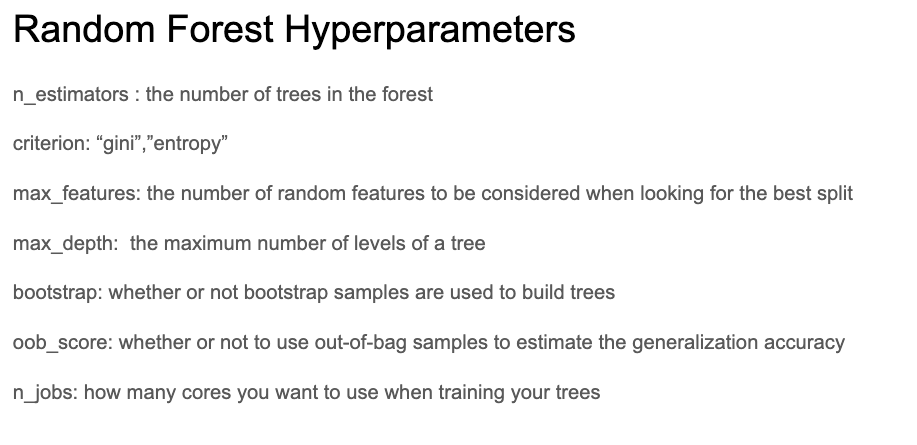

In [ ]:
# Instantiate and fit a RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100,random_state=10)
forest.fit(data_train, y_train)

In [ ]:
# Forest with genus
predrf = forest.predict(data_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, predrf))
print(classification_report(y_test, predrf))

In [ ]:
cm = confusion_matrix(y_test, predrf)
classes = ['Edible', 'Inedible']
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [ ]:
# Training accuracy score
forest.score(data_train, y_train)

In [ ]:
plot_feature_importances(forest)

In [ ]:
# Test accuracy score
forest.score(data_test, y_test)

### Now get ROC for Random Forest (currently under repair)

In [ ]:
predrf

In [ ]:
np.array(y_test)

In [ ]:
fpr

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, predrf)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for random forest')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

## Logistic Regression

In [ ]:
data = pd.get_dummies(df.drop(columns=['name', 'howEdible', 'genus']))
y = df['howEdible']
y=y.map({'edible': 1, 'inedible': 0})
#break up data for testing and training
X_train, X_test, y_train, y_test = train_test_split(data, y,test_size=.2)
data.head()

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

In [ ]:
#idk if this works for classification
dictionary = dict(zip(list(X_train.columns), list(logreg.coef_[0])))
dictionary

In [ ]:
# make class predictions for the testing set
y_pred_class = logreg.predict(X_test)

In [ ]:
# calculate accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

In [ ]:
# Confusion matrix and classification report
print(confusion_matrix(y_test, y_pred_class))
print(classification_report(y_test, y_pred_class))

In [ ]:
cm = confusion_matrix(y_test, y_pred_class)
classes = ['Edible', 'Inedible']
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_class)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Logistic Regression')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [ ]:
y_pred_class

## Reassign features and Target Variables

In [ ]:
# data = pd.get_dummies(df.drop(columns=['name', 'howEdible', 'genus']))
# y = df['howEdible']
# #break up data for testing and training
# data_train, data_test, y_train, y_test = train_test_split(data, y,test_size=.2)
# data.head()

## Use XGBoost on df without genus

In [ ]:
from xgboost import XGBClassifier

In [ ]:
# Instantiate XGBClassifier
clf = XGBClassifier(n_estimators=1000,random_state=1)

In [ ]:
# Fit XGBClassifier
clf.fit(data_train, y_train)

In [ ]:
# Predict on training and test sets
training_preds_XG = clf.predict(data_train)
test_preds_XG = clf.predict(data_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds_XG)
test_accuracy = accuracy_score(y_test, test_preds_XG)

In [ ]:
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

In [ ]:
# Confusion matrix and classification report
print(confusion_matrix(y_test, test_preds_XG))
print(classification_report(y_test, test_preds_XG))

In [ ]:
cm = confusion_matrix(y_test, test_preds_XG)
classes = ['Edible', 'Inedible']
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [ ]:
clf.score(data_train, y_train)

In [ ]:
# Test accuracy score
clf.score(data_test, y_test)

## Gridsearch CV


In [ ]:
from sklearn.model_selection import GridSearchCV
#tuning process
param_grid = {
    'learning_rate': [0.1, ],
    'max_depth': [8,10,12],
    'min_child_weight': [1],
    'subsample': [0.5,.7],
    'n_estimators': [500,2000],
}

grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=3, n_jobs=1)
grid_clf.fit(data_train, y_train)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(data_train)
test_preds = grid_clf.predict(data_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

In [ ]:
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

In [ ]:
cm = confusion_matrix(y_test, test_preds)
classes = ['Edible', 'Inedible']
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

### Look at AUC and ROC curves